In [ ]:
import pymannkendall as mk
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from descartes import PolygonPatch
import matplotlib.path as mplPath
## for plotting a polygon
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import shapefile as shp
import regionmask
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [ ]:
temp = xr.open_dataset('C:/Dinis_MOZ/corr/SST_1980_2020_normal.nc')
#temp

In [ ]:
temp.coords['longitude']=(temp.coords['longitude']+180)%360-180
temp=temp.sortby(temp.longitude) 

In [ ]:
###For Annual Trends Only
dat_samp =temp['sst'].groupby('time.year').mean('time')    ## Group data into yearly means for annual trends

In [13]:
slope_val = np.zeros((len(dat_samp.latitude.values),len(dat_samp.longitude.values)))
p_value = np.zeros((len(dat_samp.latitude.values),len(dat_samp.longitude.values)))
#output = []
for i in np.arange(len(dat_samp.latitude.values)):
    for j in np.arange(len(dat_samp.longitude.values)):
        
        try:
            slope_val[i,j] = mk.original_test(dat_samp[:,i,j]).slope  ## trend,h,p,z,tau,s,var_s,slope,intercept = mk.original_test(x,0.05)
            p_value[i,j] = mk.original_test(dat_samp[:,i,j]).p
        except:
            slope_val[i,j] = np.nan
            p_value[i,j] = np.nan

In [15]:
## Define data as Xarray dataset and save as netcdf
output1=xr.DataArray(slope_val, dims=('latitude', 'longitude'), coords={'latitude':dat_samp.latitude, 'longitude':dat_samp.longitude}, attrs=dict(description="slope.", units="sst year-1"),)
data1 = output1.rename("trend")

output2=xr.DataArray(p_value, dims=('latitude', 'longitude'), coords={'latitude':dat_samp.latitude, 'longitude':dat_samp.longitude}, attrs=dict(description="significance",),)
data2 = output2.rename("p_val")
#data2
## Save Data as netcdf
#data1.to_netcdf(home_dir + data_dir +'Af_tmean_1991-2021_Annual_trend.nc', mode='w')
#data2.to_netcdf(home_dir + data_dir +'Af_tmean_1991-2021_Annual_pvalue.nc', mode='w')

In [16]:
trnd = data1        
pval = data2

C:\Users\Samuel-NUIST\AppData\Local\Temp\ipykernel_14020\3497779571.py:7: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.gcf().subplots_adjust(hspace=0, wspace=0.08)


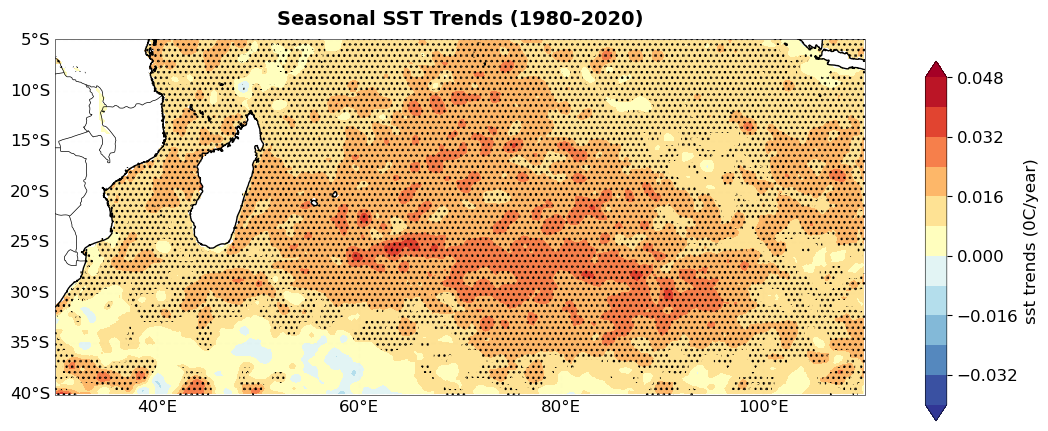

In [22]:
from matplotlib.colors import ListedColormap
none_map = ListedColormap(['none'])
fig = plt.subplots(constrained_layout=True, figsize=(12, 6))
mpl.rcParams['font.family'] #= 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 0.4
plt.gcf().subplots_adjust(hspace=0, wspace=0.08)
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=0))

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.01, linestyle='--')
gl.xlabels_top = False; gl.ylabels_left = True; gl.ylabels_right=False; gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER

## Change this to the threshold you need.
#cond = (pval >= -0.05) & (pval <= 0.05)
cond = (pval <= 0.05)
## Mask out the areas that do not satisfy the conditions
sig_reg = pval.where(cond)
cs = plt.contourf(dat_samp.longitude, dat_samp.latitude, trnd.values[:,:],  
               levels=np.arange(-0.04, 0.05, 0.008), cmap=plt.cm.RdYlBu_r, extend='both') #RdBu #YlOrRd,YlOrBr,YlOrBr  #levels=np.arange(-9, 12, 3)
## make a hatch of significance
hatch = ax.pcolor(dat_samp.longitude, dat_samp.latitude, sig_reg.data[:,:], cmap=none_map, 
                 hatch='...', edgecolor='black', lw=0, zorder=4)

# Adding geographical features
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, color='black', linewidth=0.5)
## title attributes
plt.title('Seasonal SST Trends (1980-2020)',fontsize=14, fontweight='bold')
plt.xticks(size = 10, fontweight='bold')
plt.yticks(size = 10, fontweight='bold')
##labling the axis
plt.ylabel('Latitude',fontsize=14, fontweight='bold')
plt.xlabel('Longitude',fontsize=14, fontweight='bold')
##ploting the legend
plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)
#####cax = plt.axes([0.85, 0.1, 0.018, 0.6])s
###plt.colorbar(cax=cax)
plt.colorbar(cs, ax=ax,cax = plt.axes([0.85, 0.1, 0.018, 0.6]), label='sst trends (0C/year)')
# save output
plt.savefig('C:/Dinis_MOZ/corr/SST_trends_1980_2020.png')
plt.show()